# Using Stitiches

The objective here is to walk through an example of using the stitches package to generate some stitched products from a single place.

In [30]:
import pandas as pd
import pkg_resources
import stitches as stitches
import xarray as xr

# For help with plotting
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = 12, 6

Load the archive data we want to match on, for this example we will be working with data that is included in the stitiches package so will need to use `pkg_resources` to access it.

In [8]:
archive_path = pkg_resources.resource_filename("stitches", "data/matching_archive.csv")
data = pd.read_csv(archive_path)

Subset the data into the target data and the archive data.

In [9]:
target_data = data[data["model"] == "BCC-CSM2-MR"]
target_data = target_data[target_data["experiment"] == "ssp245"]
target_data = target_data[target_data["ensemble"].isin(["r4i1p1f1", "r1i1p1f1"])]
target_data = target_data.reset_index(drop=True)

archive_data = data[data["model"] == "BCC-CSM2-MR"].copy()

Do the matching & generate the recipes.
** The following blocks of code may change.


In [ ]:
# Use the match_neighborhood function to generate all the matches between the target and archive data points.
match_df = stitches.match_neighborhood(target_data, archive_data, tol=0.1)

unformatted_recipe = stitches.permute_stitching_recipes(
    N_matches=4, matched_data=match_df, archive=archive_data
)

recipe = stitches.generate_gridded_recipe(unformatted_recipe)
recipe.columns = [
    "target_start_yr",
    "target_end_yr",
    "archive_experiment",
    "archive_variable",
    "archive_model",
    "archive_ensemble",
    "stitching_id",
    "archive_start_yr",
    "archive_end_yr",
    "tas_file",
]

## Global Products


In [11]:
outputs = stitches.gmat_stitching(recipe)

/Users/dorh012/Documents/2021/cleanup_stitch/stitches/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [23]:
# Still learning how to do all the plotting
outputs.head(3)

,year,value,variable,stitching_id
655,1850,-0.666043,tas,ssp245~r1i1p1f1~1
656,1851,-0.736022,tas,ssp245~r1i1p1f1~1
657,1852,-0.639106,tas,ssp245~r1i1p1f1~1


## Gridded Products

In [29]:
# This is the most time intensive step
outputs = stitches.gridded_stitching("/Users/dorh012/Desktop/", recipe)

In [31]:
# Load one of the output files
out = xr.open_dataset(outputs[0])

In [33]:
# Checkout the attributes
out.attrs

{}

In [32]:
# The temp attributes
out.tas.attrs

{'units': 'K',
 'variable': 'tas',
 'experiment': 'historical',
 'ensemble': 'r1i1p1f1',
 'model': 'BCC-CSM2-MR',
 'stitching_id': 'ssp245~r1i1p1f1~3',
 'recipe': '   target_start_yr target_end_yr archive_experiment archive_variable archive_model archive_ensemble       stitching_id archive_start_yr archive_end_yr                                                                             tas_file variable\n0             1850          1858         historical              tas   BCC-CSM2-MR         r1i1p1f1  ssp245~r1i1p1f1~3             1850           1858     gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/      tas\n1             1859          1867         historical              tas   BCC-CSM2-MR         r1i1p1f1  ssp245~r1i1p1f1~3             1913           1921     gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/      tas\n2             1868          1876         historical              tas   BCC-CSM2-MR         r1i1p1f

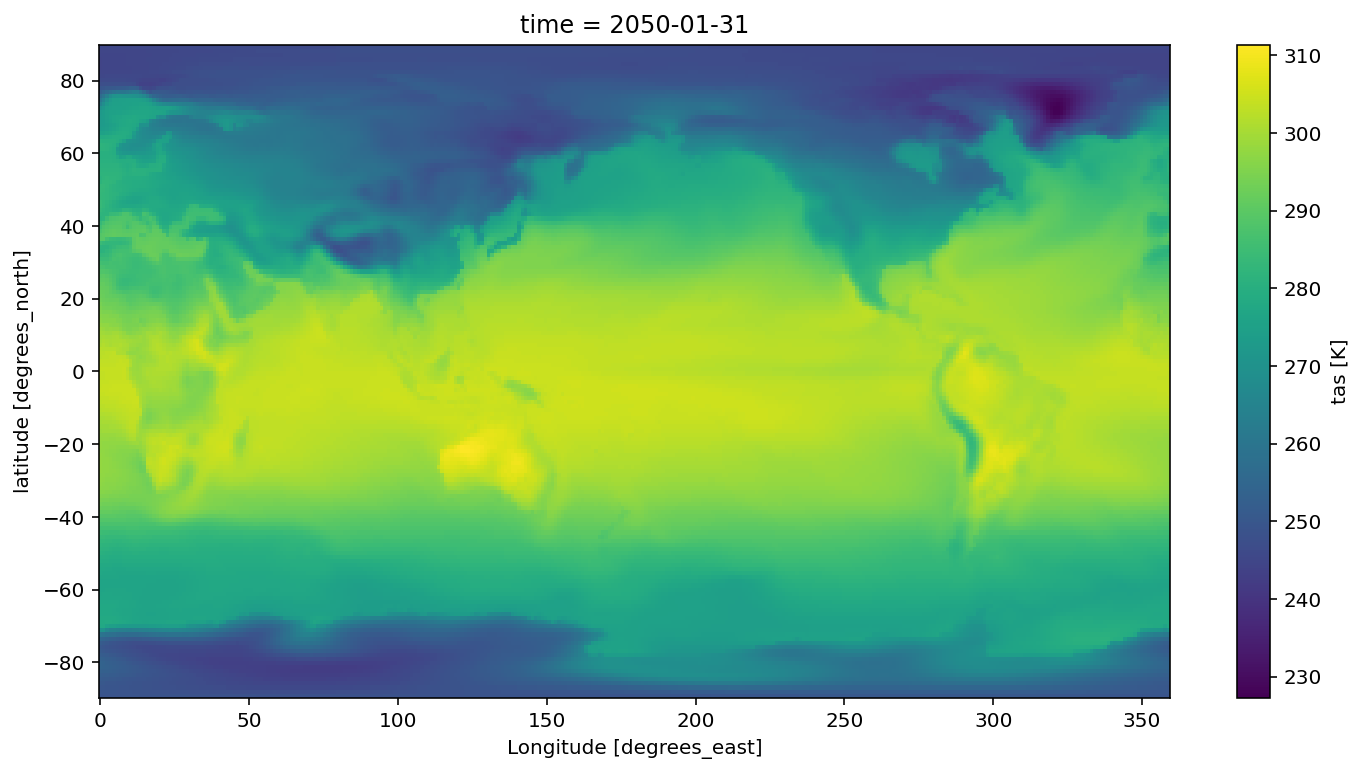

In [34]:
out.tas.sel(time="2050-01").squeeze().plot()